In [1]:
from IPython.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import nibabel
from scipy.stats import gamma

# Enable plots inside the Jupyter Notebook
%matplotlib inline

# MRI part 1: MRI data manipulation and correlation

Authored by *Shannon Tubridy*, *Hillary Raab*, and *Todd Gureckis*  
Aspects borrowed from [Carsten Klein's Intro to fMRI analysis in Python](https://github.com/akcarsten/fMRI_data_analysis).



This lab will introduce you to manipulating fMRI data in python and will apply the correlation and regression concepts from previous sections

### Introduction to MRI data

MRI scanners can be used to create 3D images. The scanners can be tuned to be sensitive to different kinds of physical materials present in the object (like a brain) being imaged.

The two primary image types that are used in cognitive neuroscience are __structural__ (sometimes called __anatomical__) and __functional__ images.



<img src="./images/brain_basics.svg">

Structural images provide information about the anatomy of what's being imaged by showing differences between different kinds of tissues, bone, cerebro-spinal fluid and so on. A structural MRI image is a relatively high spatial resolution (compared to fMRI) 3D image that can be used to assess the internal anatomy of individual brains.

Functional MRI scans produce a set of 3D images recorded over time. These images have lower spatial resolution than structual images. But unlike structural images, fMRI scans measure a signal that is related to neural activity. 

The BOLD signal commonly measured with fMRI is a time-varying signal modulated by changes in the oxygen content of blood. For people interested in the brain and behavior this is useful because that change in the oxygen content of blood is related to neural activity.

This means that researchers can record the BOLD signal from locations throughout the brain while people engage in a variety of cognitive and perceptual tasks. By assessing whether the BOLD fMRI signal in different brain areas changes in response to changes in people's perceptual or cognitive states researchers are able to make advances in understanding how our brains produce our thoughts and behavior.

Let's get into some data.

### Loading data

First, we start with importing the libraries for downloading, organizing and visualizing the data, which comes from the [SPM homepage](http://www.fil.ion.ucl.ac.uk/spm/). SPM is a popular Matlab Toolbox for analyzing fMRI brain imaging data and on their homepage some example datasets are provided.

(There are a number of data pre-processing steps involved in going from the MRI scanner to the data we're going to download here. These primarily have to do with accounting for distortions, artifacts, or other unwanted contaminations of the signal of interest. Although those preprocessing steps are crucial for the kinds of data examined in this notebook, they tend to be less related to questions about cognition and perception and so we'll jump ahead.)

[link to fMRI data once its been downloaded](./fMRI_data)

In [2]:
# Define the URL of the data and download it using the Requests libary
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
data = requests.get(url)

# this notebook needs to download ~100MB of data into the path listed in destination_dir
destination_dir = '.'

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists(destination_dir + '/fMRI_data/') == False:
    try:
        os.makedirs(destination_dir + '/fMRI_data/')
    except:
        print('destination_dir ' + destination_dir + ' doesn''t exist and/or it can''t be created')
    
open(destination_dir + '/fMRI_data/' + 'data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile(destination_dir + '/fMRI_data/' + 'data.zip', 'r')
zip_ref.extractall(destination_dir + '/fMRI_data/')
zip_ref.close()

Let's take a look at what we downloaded. In the cell above we set the destination directory to be the directory that this notebook is running from (the `'.'` from up above) and we created a subfolder inside of there called `/fmri_data/` using os.makedirs.

By clicking [here](./FMRI_data) in Jupyter you will open a new browser window that allows you to look at Jupyter's local files, including those we just downloaded. Take a look.

As you can see, un-zipping the file gives us two folders with various files inside them. The first folder ("./sM00223/") contains a high-resolution structural scan of the subject. 

The functional data are located in the other folder ("./fM00223/"). 

You'll notice that there pairs of files in these folders. These pairs have the same filename but one has the extension .hdr and the other has the exenstion .img. The .hdr is a file that contains meta-information related to the MRI data collection and the .img files have the actual MRI data inside.

The NiBabel package provides tools for using python to read and write MRI-related file types like `.hdr`, `.img`, and `.nii`.

First let's read in the structural data using the the NiBabel package. 

In [7]:
# Find all files in the structural data folder
data_path = destination_dir + '/fMRI_data/' + 'sM00223/'
files = sorted(os.listdir(data_path))

# take a look at what files are listed:
print(files)

# Read in the data by looping over the list of files and if the last three characters in the name are hdr
# then we will use nibabel to load the data
for data_file in files:
    # chec
    if data_file[-3:] == 'hdr':
        structural_data = nibabel.load(data_path + data_file).get_fdata()    

['sM00223_002.hdr', 'sM00223_002.img']


Now let's load the functional data. 

There is a README.txt file that comes with the dataset. The README.txt includes details of the data acquisition that we need to read the files. The key parameters we have to know are the size of each image, the number of slices that were collected and how many volumes were acquired; that is the number of timepoints that were sampled.

In [9]:
# Basic information about the data acquisition
# how big is the x dimension?
x_size = 64
# how big is the y dimension?
y_size = 64
# how big is the z dimension (called slices here)?
z_size = 64
# How many volumes were collected? It's one volume per timepoint, so this is also how many 
# timepoints we have in our functional data
n_volumes = 96

# Find all files in the data functional data folder
data_path = destination_dir + '/fMRI_data/' + '/fM00223/'
files = sorted(os.listdir(data_path))

# Read in the data and organize it with respect to the acquisition parameters
# The data are stored as one volume with dimensions 64x64x64 for each timepoint
# We will loop over the files, load them one at a time using nibabel storing the single 
# timepoint data in `data`, and appending each timepoint to `data_all` so that we end up with 
# a list of numpy arrays
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr' and data_file[0] == 'f':
        data = nibabel.load(data_path + data_file).get_fdata()        
        data_all.append(data.reshape(x_size, y_size, z_size))
        
# do some bookkeeping and index swapping so that end up with a 4D numpy array with dimensions
# x,y,z, and time
functional_data = np.transpose(np.array(data_all),(1,2,3,0))
# rotate into same alignment as struct image
functional_data = np.rot90(functional_data)

We have loaded our MRI data and we have stored them in numpy arrays. 

Numpy arrays are a way to store data in python. You have seen them before here and there in previous sections but we will make extensive use of them in this section so let's orient ourselves.

A numpy array has $N$ dimensions, and each of the dimensions can have some number of elements stored inside of it.

That description is kind of abstract so let's make it concrete.

Here is the image from the introduction to this notebook.

<img src="./images/brain_basics.svg">



Take a look at the schematic of the structural data.

The data are three dimensional because we have created an image of a three-dimensional object. For the structural data we can think about three spatial dimensions $x$, $y$,  $z$.

The large 3D box that covers the whole head is called a ***volume***.

If you look again at the example illustration you'll see that each dimension of the volume is segmented into a number of smaller boxes or voxels. The number of voxels along each dimension is the length of that dimension. 

In this illustration the length of each dimension is nine voxels, so the total number of voxels in the volume is 9 x 9 x 9 (length x width x height).

We can check the dimensions of our actual data array using `shape` like we did with dataframes. Dataframes are 2 dimensional and the number of elements per dimension corresponds to the number of rows and columns. 

Let's see what the shape of our structural data is:

In [10]:
structural_data.shape

(256, 256, 54, 1)

This output tells us that we have four dimensions to our data. 

The first three are the spatial dimensions (so our 3D box is 256 x 256 x 54 voxels in size). The fourth dimension is time $t$. 

One way to think about this is that there is a 3D array of size 256x256x54 covering the brain and there is a version of this box for every element in the fourth dimension of time.

For the structural image there is only one number for a single timepoint and voxel because we are recording the overall structure of the brain, which does not change from moment to moment.

For convenience we can get rid of the fourth dimension because it doesn't have any information. We'll use a numpy method called squeeze, which basically flattens any dimensions that have length == 1 and at the same time we'll rotate the image 90 degrees for viewing purposes.

In [11]:
structural_data = np.rot90(structural_data.squeeze(), 1)

# now let's check the shape again:
structural_data.shape


(256, 256, 54)

OK, now we have our structural data in a single 3D array just like in the illustration.

<div class="alert alert-info" role="alert">
  <strong>Question 1</strong> <br>
    The `functional_data` is also in a numpy array. What is the shape of the functional_data array? How many timepoints are in the functional data?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Indexing numpy arrays

The value of individual elements in a numpy array can be obtained by giving the appropriate indices. In both our structural and functional MRI data every voxel has a position in the $x$, $y$, $z$ space defined by the three spatial axes.


Let's look at the value of a voxel from the structural image:

In [12]:
x_coordinate = 30
y_coordinate = 40
z_coordinate = 25
one_voxel_value = structural_data[x_coordinate, y_coordinate, z_coordinate]
print(one_voxel_value)

2.0


Ok... so the value of that voxel is 2. What can we do with that number? On its own we can't do much, but by looking at the values of many voxels at once we can begin to look at images of our data.

The data are 3D, so we cannot directly view an image of the whole 3D array, so instead we will look at ***slices*** through the volume.

In the illustration of structural and functional data that we've been looking there is an example of a slice shown in orange.

Slicing the data like this means taking all of the values in two of the dimensions for a single location in the remaining dimension. In the illustration the orange slice is all of the elements of the $y$ and $z$ dimensions for a fixed value of $x$.

In the indexing example above we gave a single coordinate or index value for each of the x,y, and z dimensions, but we can also easily take all of the values from a dimension using `:` as shown in the cell below.



In [13]:
# make a numpy array of sequential numbers
my_array = np.array(range(0,12))

# check the shape
print(my_array.shape)

# ok there is only one dimension and it has 12 elements in it
# as is usual in python the elements in each dimension are indexed starting at zero
# let's take a look at the first element of my_array
first_element = my_array[0]
print('the first element is ' + str(first_element))

# how about the fifth element?
fifth_element = my_array[4]
print('the first element is ' + str(fifth_element))

# and now let's take all of the elements using the `:` indexer
all_elements = my_array[:]
print('all the elements in the array:')
print(all_elements)


(12,)
the first element is 0
the first element is 4
all the elements in the array:
[ 0  1  2  3  4  5  6  7  8  9 10 11]


Now let's try viewing 2D slices of our structural data. 

Take a look at the code in the next cell at the line starting with `ax.imshow` and see if you can figure out what's going on with the structural_data array.

In that line we are taking all of the elements in the first two dimensions for a single position in the third dimension specified in the variable `slice`.

This little widget allows you to drag the slider to change the slice that we are taking, letting us move up and down through the brain viewing a series of 2D views (horizontal slices).

Give it a try.

In [14]:
@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_struct(slice):
    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    ax.imshow(structural_data[:,:,slice],'gray')
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

Alright, that looks like a brain in a skull. For your orientation we are looking at the person's brain from the top with slice 0 being the lowest one and slice 53 at the top of the head. This is known as an "axial" or "transverse" view of the brain.

If you want to know more about this concept check out the respective [Wikipedia page](https://en.wikipedia.org/wiki/Anatomical_plane).

<div class="alert alert-info" role="alert">
  <strong>Question 2</strong> <br>
    Use the slider to move through slices in the structural image. Can you find the eyes? What is the index of the slices where you can see the eye?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

Now let's turn back to the functional data.

In [15]:
functional_data.shape

(64, 64, 64, 96)

If we want to view 2D views of the fuctional data we need to select a plane in which we "cut" or slice the brain like in the structural image, but we also have a fourth dimension of time that is 96 elements long. This means we have a version of our 64x64x64 box at each of 96 timepoints, representing the measured BOLD signal in each voxel at each of 96 timepoints.

So if we want to plot we need to choose one of the spatial dimensions to slice through and also a single timepoint for which we'd like to see that plane.

Here is a version of the slider image we looked at before using the structural data, but now using the functional data.

In [16]:
@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_functional(slice):
    tp=3
    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    ax.imshow(functional_data[:, :, slice, tp],'gray')
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

Can you find the eyes in this image? How does it look compared to the structural image?

<div class="alert alert-info" role="alert">
  <strong>Question 2</strong> <br>
    Take a look at where we index the functional_data array in the `plot_functional` function. Can you tell which timepoint we are using for plotting these data?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Timecourse of activation for a single voxel

The images we just created show the BOLD activation value in all the voxels in a slice at a single point in time. But one of the things we'd like to use fMRI data for is to evaluate whether an individual voxel's signal change over time is related to a cognitive or perceptual task.

So let's take a single voxel and look at its timecourse of activation. To do this we will use the same logic as for plotting a 2d slice, but now we will give a single index for the x, y, and z dimensions, corresponding to a single voxel's coordinates in 3D space, and then take all the values from the fourth dimension (time) using ':'.

In [17]:
x_coord = 30
y_coord = 30
z_coord = 35

# get all of the values over time for a single voxel
one_voxel_timecourse = functional_data[x_coord, y_coord, z_coord, :]

<div class="alert alert-info" role="alert">
  <strong>Question 3</strong> <br>
    What is the shape of our one_voxel_timecourse variable? What does that number correspond to?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

Let's plot the timecourse of activation for that voxel.

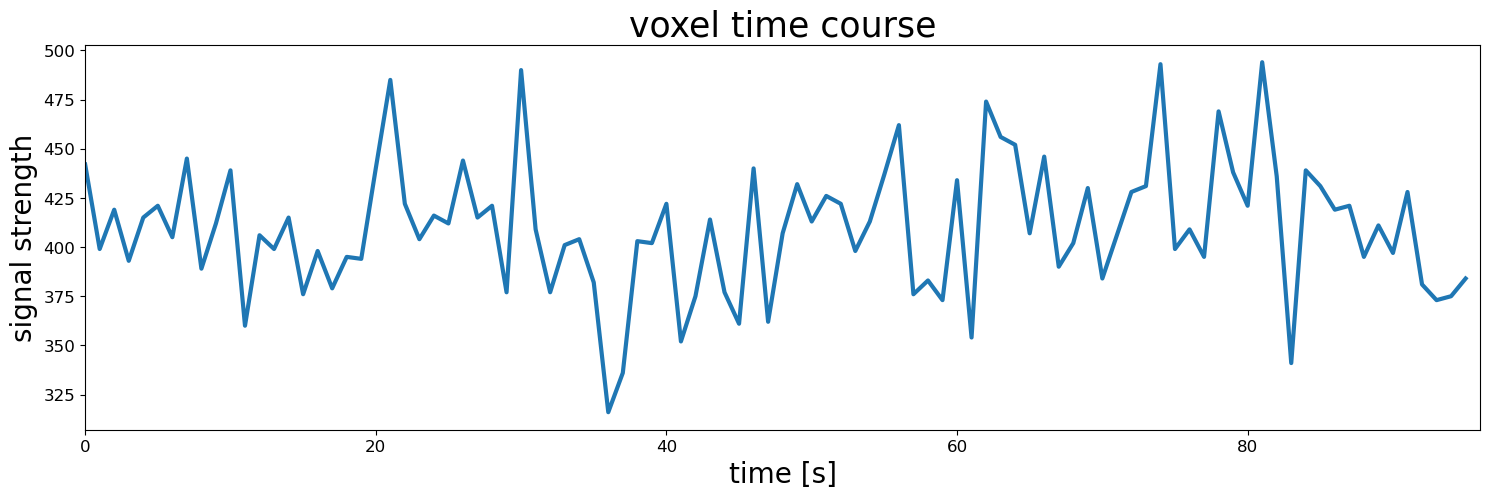

In [18]:
# Create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

x_coord = 30
y_coord = 30
z_coord = 35

# get all of the values over time for a single voxel
one_voxel_timecourse = functional_data[x_coord, y_coord, z_coord, :]

# Plot the timecourse of a random voxel
ax.plot(one_voxel_timecourse, lw=3)
ax.set_xlim([0, one_voxel_timecourse.shape[0]])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

plt.show()

Hmm. Looks like data. What if we plot some the signal timecourse from some more voxels?

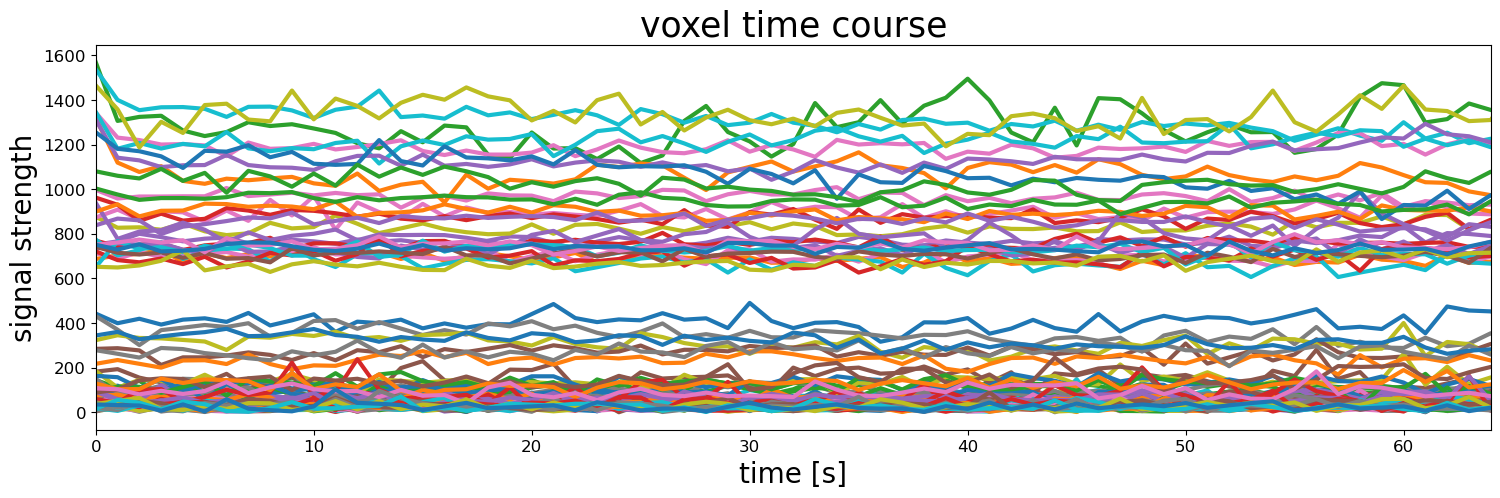

In [19]:
# Create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

# voxel indices for one voxel
x_coord = 30
y_coord = 30
z_coord = 35

# Plot the timecourse of a random voxel from the transveral array
ax.plot(functional_data[x_coord, y_coord, z_coord, :], lw=3)

# choose some more voxels at random  and plot 100 more voxel timecourses
# COMPREHENSION CHECK: why do we choose a random index value between 0 and 64? Why not 0 and 100?
n_voxels_to_plot=100
for _ in range(0, n_voxels_to_plot):
    x_coord = np.random.randint(64)
    y_coord = np.random.randint(64)
    z_coord = np.random.randint(64)
    ax.plot(functional_data[x_coord, y_coord, z_coord, :], lw=3)

ax.set_xlim([0, functional_data.shape[0]])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

plt.show()

This is the timecourse for 100 voxels in our participant's brain. How can we make sense of all these data? 

Even with the small number of voxels plotted above we can see that the activation timecourses differ in their average level of signal as well as their dynamics over time. In order to get more insights out of this kind of data we need to put more effort into analyzing the temporal dimension of the data.

### Voxel timecourses and correlation

One of the most direct ways to understand fMRI data is to see whether different voxel timecourses correlate with some predictor variable of interest. We will unpack this throughout the rest of this and the next MRI labs, but it should seem familiar: we have already seen examples of computing the correlation between two sets of numbers to understand whether there is a relationship between them. 

We also saw that in some ways regression operates in a related way where we'd like to find the closest match between predictor variable (sleep) and the values of some measured outcomes (grumpiness). Later we will explore this idea further by seeing if we can relate the stimuli that a participant was perceiving to the responses in their brain but for now let's warm up by revisiting correlation and using some of our new knowledge about indexing numpy arrays.

<div class="alert alert-info" role="alert">
  <strong>Question 3</strong> <br>
    Get the full timecourse for two voxels in the functional data (you'll need a different set of x,y,z coordinates for each voxel and all of the values in the time dimension of the functional_data array). Take a look back at the "Timecourse of activation for a single voxel" section above if you need a reminder on how to get the timeseries for one voxel.
    
Once you have the activation values for each voxel you should (A) plot them on the same plot using the sample code below; (B) compute the correlation coefficient (<i>r</i> value) between the two timeseries.
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here. You can adapt the example plotting code below and add your correlation code.
</div>

In [ ]:
# example for plotting two timeseries on the same plot

# Create an empty plot with defined aspect ratio
# ax is the 'handle' for the plot and we use it to tell python where to put the data we're plotting
fig, ax = plt.subplots(1, 1, figsize=[18, 5])


# You'll need to get the timeseries of activation for two voxels and put them in these two variables:
voxel_1_tc = 
voxel_2_tc = 

# Plot the timecourse of each voxel to the current axes
ax.plot(voxel_1_tc, lw=3, label='voxel_1_tc')
ax.plot(voxel_2_tc, lw=3, label='voxel_2_tc')

ax.set_xlim([0, voxel_1_tc.shape[0]])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)
ax.legend()

plt.show()

### Relating brain data to the experimental protocol

Congratulations! You're on your way to analyzing fMRI data. In the example above we computed the correlation between two voxels' timeseries.

The general approach to analyzing fMRI data builds on this approach but instead of correlating a voxel timeseries with another voxel timeseries (although we will return to this later) we see whether there is a relationship between a predictor variable representing the cognitive or perceptual context over the course of the experiment and any individual voxels. If the predictor variable composed from the cognitive or perceptual considerations of the experiment can ***explain*** the variation in a voxel timeseries we would have some evidence on which to make inferences about what that part of the brain is doing.

The data we have been playing with in this notebook come from an experiment in which the participant alternated between listening to spoken words or hearing nothing.

So let's think: 

How would you imagine the brain-signal response to look in a study like this? If a part of the brain was involved in processing spoken verbal stimuli what would we predict its activation to look?

For now, let's keep things simple and just assume that without a stimulus (the playing of "bi-syllabic words") the signal in a sound-sensitive part of the brain is at a baseline level and during the auditory stimulation the signal goes up.

Let's make a simple "model" of what that would look like. 

In order to do it we will need some details about the experiment and MRI scanning. We'll come back to this later, but for now let's use them to make a timecourse of what we think it would like for a brain region to be "active" during auditory stimulation and "silent" during rest (no stimulation).

In [25]:
# These are the main parameters of the fMRI scan and experimental design
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

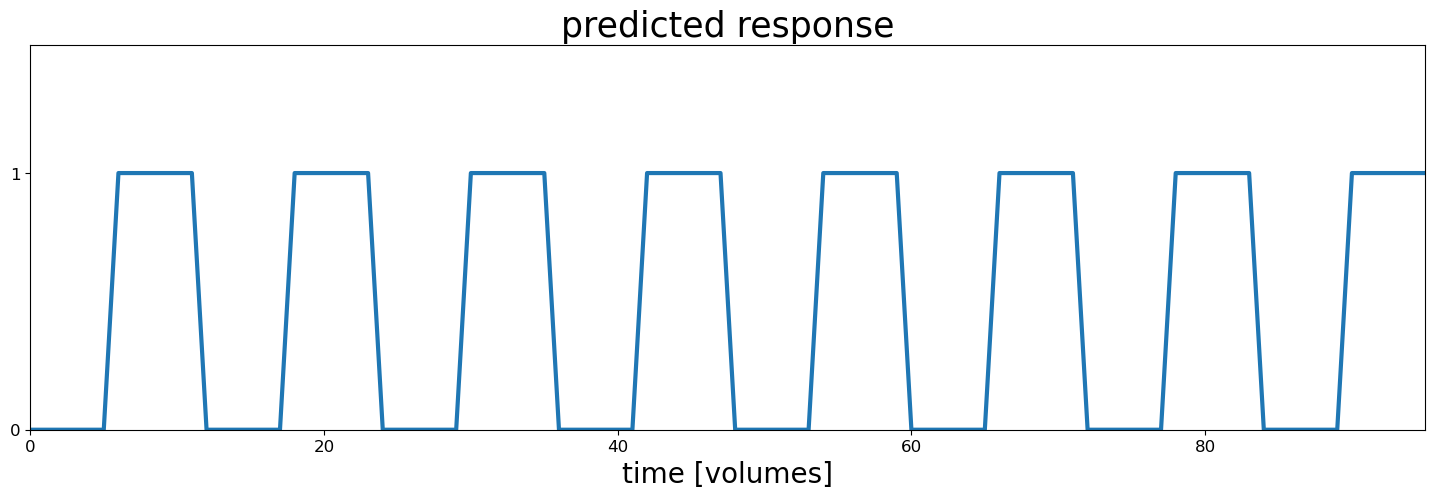

In [26]:
# we can use the experimental parameters to make timecourse plot showing when the auditory stimulation happened
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(predicted_response, lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(0, 1.5)
ax.set_title('predicted response', fontsize=25)
ax.set_yticks([0,1])
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
ax.tick_params(labelsize=12)

# fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Let's take a moment to look at this plot. This represents the timecourse of auditory stimulation in the our experiment. The x-axis represents time and the y-axis shows whether sound was on ($y=1$) or off ($y=0$).

This is the set of values, one for each point in time that we will use to try to understand the fMRI data collected in this experiment. We will search through the brain, looking to see whether any voxel timeseries are well explained by this predicted response and if they are we might conclude that they are involved in hearing.

Before we conduct a full brain regression let's try a correlation approach.

We will use np.corrcoef() to compute the correlation between between the predicted response and all the voxel timeseries.

Actually we won't do it for all the voxel timeseries because there are a lot of them and it will either take a long time or crash our computer.

<div class="alert alert-info" role="alert">
  <strong>Question 4</strong> <br>
    How many total voxels are in our functional dataset? In other words, how many elements are there in the 3D grid contained in the functional data array?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

Yeah, that's too many voxels to run all at once right now. 

Let's take a slice of our data:

In [27]:
one_slice_data = functional_data[:,:,36,:]
one_slice_data.shape

(64, 64, 96)

Now we need to turn this 3D array (x,y, and t) into a 2D array to use in np.corrcoef. We can use the numpy reshape function:

In [28]:
n_slice_voxels = one_slice_data.shape[0]*one_slice_data.shape[1]
one_slice_data_2d = np.reshape(one_slice_data, (n_slice_voxels, one_slice_data.shape[2]))
one_slice_data_2d.shape

(4096, 96)

OK great, now we have voxels by time. Let's see if any of the voxel timeseries correlates with our predicted response

In [29]:
#### np.corrcoef does not return the p value so we will use scipy.stats.pearsonr instead

# c = np.corrcoef(predicted_response, one_slice_data_2d)[1:,0]
# c.shape

In [30]:
# compute the correlation betweeen each voxel timeseries and the predicted response
# store the pearsons r value in r_values and the corresponding significance level in p_values

r_values = []
p_values = []

# loop over every timeseries in one_slice_data_2d
for idx, val in enumerate(range(0,one_slice_data_2d.shape[0])):
    r,p = stats.pearsonr(predicted_response, one_slice_data_2d[idx,:])
#     r_values.append(stats.pearsonr(predicted_response, one_slice_data_2d[idx,:])[1])
#     c_2.append(stats.pearsonr(predicted_response, one_slice_data_2d[idx,:])[1])
    r_values.append(r)
    p_values.append(p)
    



Now we have 4096 correlation values, one for each voxel in our slice, telling us how much that voxel timeseries correlated with the predictor timeseries. Let's reshape that so we can plot the correlation values as an image.



In [31]:
# we'll use some numpy convenience functions to find the indices of the voxel with the highest correlation value

# make a 2d representation of the correlation values
r_values_as_slice = np.reshape(r_values, (one_slice_data.shape[0],one_slice_data.shape[1]))
p_values_as_slice = np.reshape(p_values, (one_slice_data.shape[0],one_slice_data.shape[1]))

# get the x,y indices of the max correlation value
max_xy = np.unravel_index(r_values_as_slice.argmax(), r_values_as_slice.shape)

Let's take a look and see how the timecourse from the most correlated voxel looks compared to the predictor timecourse:

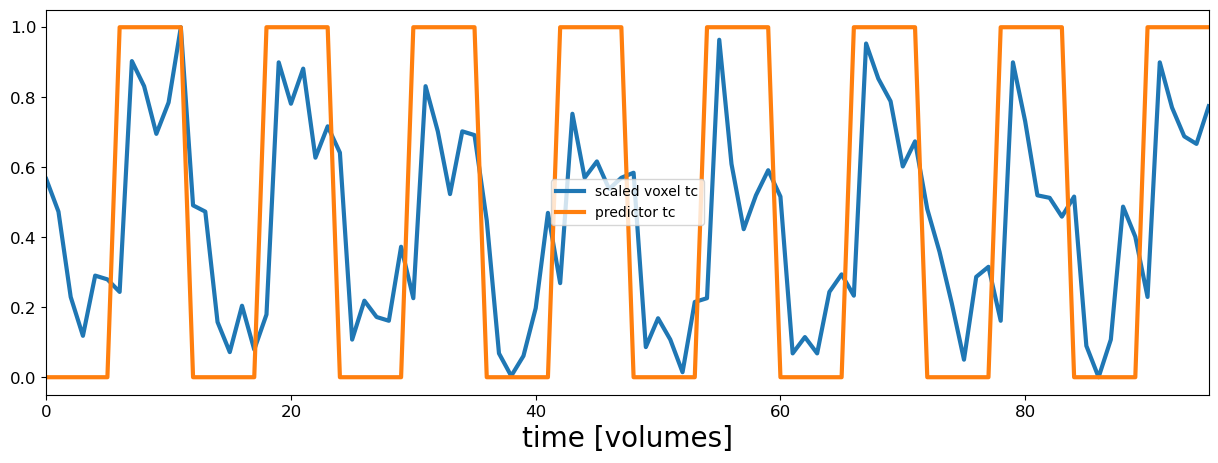

In [32]:
# use the max_xy values to get the voxel timecourse that has the highest correlation
# max_xy is the x and y coordinate of the voxel whose activation is most correlated with the predictor timecourse
max_corr_timecourse = one_slice_data[max_xy[0], max_xy[1],:]

# the raw timecourse is on a different scale that the predictor response so we will scale the values so 
# they are all between zero and one

# Define the min-max scaling function
def scale(data):
    return (data - data.min()) / (data.max() - data.min())


# Create the plots
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(scale(max_corr_timecourse), lw=3, label='scaled voxel tc')
ax.plot(predicted_response, lw=3, label='predictor tc')
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()
plt.show()

Hey that looks pretty good!

OK, now we can see that the timecourse for this voxel looks similar to our assumed response if a voxel was to respond to sound similar to the predicted timecourse. 

But how are voxels that correlate with our idealized timecourse distributed across the brain? Let's check.<br>

We will make a figure that has three panels:

One will show the image of the brain like before, the next will show an image where each voxel is colored according to the Pearson's $r$ value calculated in the correlation above, and the third image will show a "thresholded" map of the correlation values, showing only those voxels whose correlation value is above a desired threshold.

In [33]:
# use some numpy magic to get an array that is nan everywhere that the correlation value is less than .2

# first make a copy of the correlation values
r_thresholded = r_values_as_slice.copy()

# now set any values less than .2 to be equal to nan
r_thresh = .2
r_thresholded[r_thresholded < r_thresh] = np.nan

[]

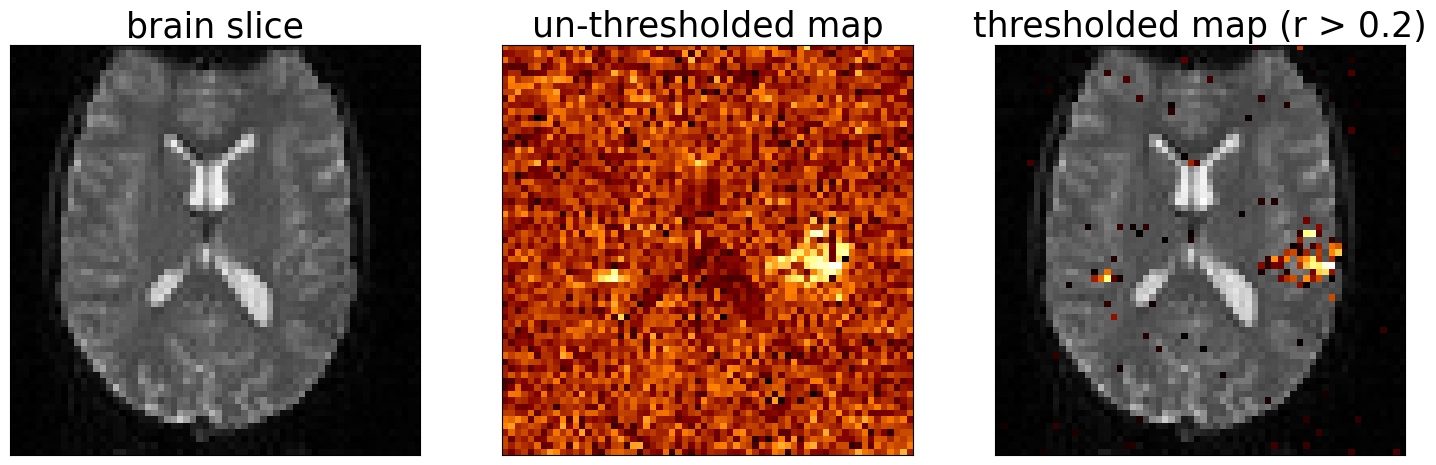

In [34]:
# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(functional_data[:,:,36,10], cmap='gray')
ax[0].set_title('brain slice', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(r_values_as_slice,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[2].imshow(functional_data[:,:,36,10], cmap='gray')
ax[2].imshow(r_thresholded, cmap='afmhot')
ax[2].set_title('thresholded map (r > ' + str(r_thresh) + ')', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

Look at that, we made some brain maps! 

And it looks like there is some structure to the data. 

The data we're looking at is oriented so that the front of the participant head is pointing up and the left/right of their head is in the left/right of the figure.

The un-thresholded map in the middle is showing correlation value for each voxel.

The thresholded map is made by finding the voxels in the untresholded map whose correlation values are above our threshold of 0.2 and overlaying them on the brain-slice image. The color of the voxels indicates the strength of the correlation (the $r$ value) with higher $r$ values in brighter colors.

The analysis we did was to measure whether any voxels correlated with our predicted response (the timeseries of auditory activation) and it seems like the voxels with the highest values are on the side of the head, possibly near the ears. Very cool!

But you also might notice that there are other voxels that are colored here. This is the issue we will return to in the next lab when we learn about dealing with multiple comparisons and false positives when you have lots of data.

As a final exercise this week, let's play with the significance threshold for plotting brain maps.

This next cell will define a convenience function to wrap up the thresholded plotting code we used to make the figure above, except we will switch and adjust the ***p*** value associated with the calculated correlation coefficients ($r$).

The ***p*** value corresponds to the "significance" of a single correlation test and represents the chances of observing an $r$ value that high by chance. This is the value that we use for the classic $p < 0.05$ threshold for deciding whether a statistical result is significant.

In the next cell we can use the slider to change the $p$-value threshold, and only those voxels whose correlation had a $p$ value ***less than*** the slide value will be plotted.

The voxels will be colored according to their $p$ value, with more significant voxels (lower $p$ values) plotted in brighter colors.

In [35]:
@widgets.interact(p_threshold=widgets.FloatSlider(min=.0000000000001, max=.3, step=.00001, value=0.3, height=40))
def plot_thresholded_brains(p_threshold):
    assert p_threshold >= 0 and p_threshold <= 1,'p_reshold should be between 0 and 1'
    # first make a copy of the correlation values
    p_thresh = p_values_as_slice.copy()

    # now set any voxels with p greater than p_threshold to be equal to nan
    p_thresh[p_thresh > p_threshold] = np.nan

    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    ax.imshow(functional_data[:,:,36,10], cmap='gray')
    ax.imshow(p_thresh, cmap='afmhot_r')
    ax.set_title('thresholded map (p < ' + str(p_threshold) + ')', fontsize=25)
    fig.subplots_adjust(wspace=0, hspace=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    

interactive(children=(FloatSlider(value=0.3, description='p_threshold', max=0.3, min=1e-13, step=1e-05), Outpu…

<div class="alert alert-info" role="alert">
  <strong>Question 5</strong> <br>
    Play with the slider, trying out different significance thresholds. What happens if you make the threshold very lenient? What happens if you make it very strict? Pay particular attention to the spatial distribution of the voxels in the thresholded map. What do you notice about the spatial arrangement of the voxels that have the most significant correlation with the predictor timecourse? Where are those voxels compared to each other? What about the voxels that are significant at p < .29? Do you notice anything funny about where some of these voxels are relative to the underlying gray brain image?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>